# CAPM

* Goal: a brief walkthrough of CAPM and APT using real stock data
* What you will learn:
    - Data wrangling
    - CAPM models
    - ggplot 

## load packages

In [1]:
require('dplyr')
require('ggplot2')
require('tidyr')
require('quadprog')

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: tidyr
Loading required package: quadprog


## set figure size

In [2]:
options(repr.plot.width=7, repr.plot.height=5)

## Get data online
Data can be obtained from here: https://stooq.com/db/h/

## Read data in raw format

In [3]:
options(warn = -1)
path =  './data'
# read the stock open into a table
files = list.files(path = path, pattern = '*.txt')
files_with_path = lapply(files, function(x) paste(path, x, sep = '/'))
print(read.csv(files_with_path[[1]]) %>% head)
stock_prices = read.csv(files_with_path[[1]]) %>% select('Date')
for (i in 1:length(files)){
    ticker = strsplit(files[[i]], split = '\\.')[[1]][1]
    a = tryCatch({read.csv(files_with_path[[i]]) %>% select('Date', 'Open')}, error = function(e) {return(NULL)})
    if (is.null(a)) {
        next
    }
    names(a)[2] = ticker
    stock_prices = stock_prices %>% left_join(a, by = c('Date' = 'Date')) 
}
print(dim(stock_prices))

        Date   Open   High    Low  Close   Volume OpenInt
1 1999-11-18 30.645 33.679 26.942 29.636 66425227       0
2 1999-11-19 28.922 28.962 26.812 27.196 16178900       0
3 1999-11-22 27.824 29.636 26.984 29.636  6985802       0
4 1999-11-23 28.624 29.381 26.942 26.942  6346195       0
5 1999-11-24 27.023 28.246 26.942 27.655  5143586       0
6 1999-11-26 27.533 27.950 27.448 27.745  1836720       0
[1] 4565 1996


## take a look of missing value rates

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


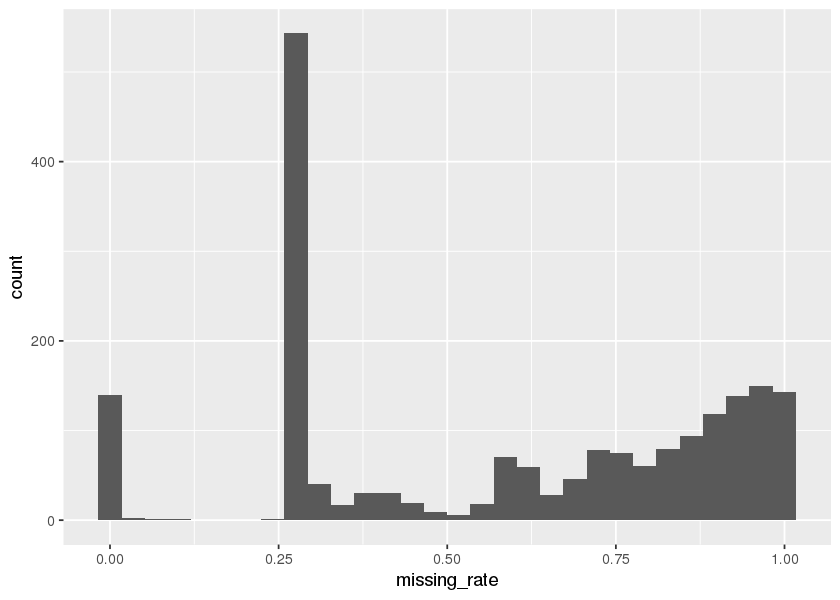

In [4]:
missing_info = stock_prices %>% gather_(key_col = 'Stock', value_col = 'Open', gather_cols = names(stock_prices)[-1]) %>%
group_by(Stock) %>% summarise(missing_rate = mean(is.na(Open))) 
missing_info %>% ggplot() + 
geom_histogram(aes(x = missing_rate), title = 'missing rate of stocks')

## dealing with missing values

In [5]:
missing_rate = colMeans(is.na(stock_prices))
partial_stock_prices = stock_prices %>% select(which(missing_rate < .3))                            
complete_stock_prices = partial_stock_prices %>% filter(complete.cases(partial_stock_prices))
print(dim(complete_stock_prices))
head(complete_stock_prices)

[1] 2686  703


Date,a,aa,aan,aap,aav,ab,abb,abc,abg,⋯,kgc,kim,kmb,kmm,kmt,kmx,knd,knl,ko,kof
2005-04-27,14.333,60.258,11.949,34.545,15.50,27.045,4.5399,13.553,14.16,⋯,5.1399,20.175,48.848,6.2663,19.714,14.28,20.627,14.531,17.352,20.366
2005-04-28,14.211,59.610,13.850,34.881,15.12,27.134,4.5873,13.666,14.00,⋯,5.0045,20.477,49.124,6.2782,19.583,14.12,22.967,14.237,17.247,20.307
2005-05-02,13.978,60.842,14.380,35.079,14.60,27.045,4.6586,13.842,13.65,⋯,5.1788,20.588,49.409,6.2482,19.826,13.60,22.790,13.613,17.595,19.723
2005-05-04,14.279,60.927,14.645,35.019,14.69,26.162,4.6745,13.944,13.92,⋯,5.3433,20.739,49.416,6.2725,19.669,14.03,23.538,13.737,17.791,19.552
2005-05-09,14.414,61.423,15.009,36.089,14.81,27.045,4.7142,14.247,14.09,⋯,5.4206,21.050,48.729,6.2051,19.906,14.35,24.216,13.569,17.881,19.723
2005-05-12,14.595,59.317,14.516,35.531,14.54,27.045,4.7776,14.392,13.95,⋯,5.1302,21.318,49.440,6.1256,19.365,13.88,24.691,13.862,18.105,19.595


## calculate the return

In [20]:
num_days = nrow(complete_stock_prices)
num_cols = ncol(complete_stock_prices)
stock_return = (complete_stock_prices[-1,2:num_cols] - complete_stock_prices[-num_days,2:num_cols])/(1 + complete_stock_prices[-num_days,2:num_cols])
rownames(stock_return) = complete_stock_prices$Date[-1]
num_stocks = num_cols - 1
head(stock_return)

,a,aa,aan,aap,aav,ab,abb,abc,abg,abm,⋯,kgc,kim,kmb,kmm,kmt,kmx,knd,knl,ko,kof
2005-04-28,-0.007956695,-0.01057821,0.146806703,0.009452806,-0.023030303,0.003173471,0.008556111,0.007764722,-0.010554090,-0.008777167,⋯,-0.02205248,0.014262102,0.0055368320,0.001637697,-0.006324225,-0.01047120,0.108198086,-0.018929882,-0.005721447,-0.002761397
2005-05-02,-0.015317862,0.02032668,0.035690236,0.005518241,-0.032258065,-0.003163432,0.012761083,0.012000545,-0.023333333,-0.005120173,⋯,0.02902823,0.005168320,0.0056858990,-0.004121898,0.011805859,-0.03439153,-0.007385155,-0.040952943,0.019071628,-0.027408833
2005-05-04,0.020096141,0.00137447,0.017230169,-0.001663017,0.005769231,-0.031485113,0.002809882,0.006872389,0.018430034,0.009324292,⋯,0.02662329,0.006994627,0.0001388641,0.003352556,-0.007538654,0.02945205,0.031441782,0.008485595,0.010540468,-0.008251701
2005-05-09,0.008835657,0.00800943,0.023266219,0.029706544,0.007648184,0.032508652,0.006996211,0.020275696,0.011394102,0.016376725,⋯,0.01218609,0.014306086,-0.0136266265,-0.009267790,0.011466447,0.02129075,0.027630614,-0.011399878,0.004789527,0.008320358
2005-05-12,0.011742572,-0.03373756,-0.030795178,-0.015044892,-0.017077799,0.000000000,0.011095166,0.009510068,-0.009277667,0.003069114,⋯,-0.04522942,0.012154195,0.0142974924,-0.011033851,-0.025877738,-0.03061889,0.018837246,0.020111195,0.011863778,-0.006176712
2005-05-16,0.007823020,-0.06616708,-0.001288992,-0.011579207,-0.080437580,-0.005134605,-0.008221407,0.005197505,-0.010033445,-0.019123272,⋯,-0.06471241,-0.015996057,-0.0062648692,0.002568205,-0.033734348,-0.02620968,0.018566813,-0.005450141,-0.011462968,-0.007137655


## save the workspace

In [10]:
save.image('workspace.RData')

In [2]:
load('workspace.RData')

## CAPM model
- Suppose we have $p$ stocks at $n$ days, and their expected return $c\in \mathbb{R}^{p\times 1}$, and their covariance matrix is $X \in \mathbb{R}^{p\times p}$
- For a weighted portfolio with weights $w\in \mathbb{R}^{p\times 1}$, the expected return is $c^Tw$ and the variance is $w^TXw$. 
- We want to minimize the variance as well as maximize the expected return, which can be achieved by

$$
\textrm{minimize  } -c^Tw + \frac{\gamma}{2}w^TXw,  \textrm{subject to  } \mathbf{1}^Tw = 1, w \geq 0,
$$
where $\gamma > 0$ is a positive real number.

- This is a convex quadratic programming problem.
- With risk-free bond return, we get the optimal $w^*$

In [21]:
gammas = exp(-10:10)
n = num_stocks
weights = matrix(NA, nrow = length(gammas), ncol = n)
c = as.vector(colMeans(stock_return))
X = cov(stock_return) 
for (i in 1:length(gammas)){
    gamma = gammas[i]
    Amat = cbind(rep(1, n), diag(1, n))
    bvec = as.vector(c(1, rep(0, n)))
    out = solve.QP(dvec = c/gamma, Dmat = X, Amat = Amat, factorized = FALSE, bvec = bvec, meq = 1)
    weights[i, ] = out$solution
}

Warning message:
“Removed 8 rows containing missing values (geom_path).”

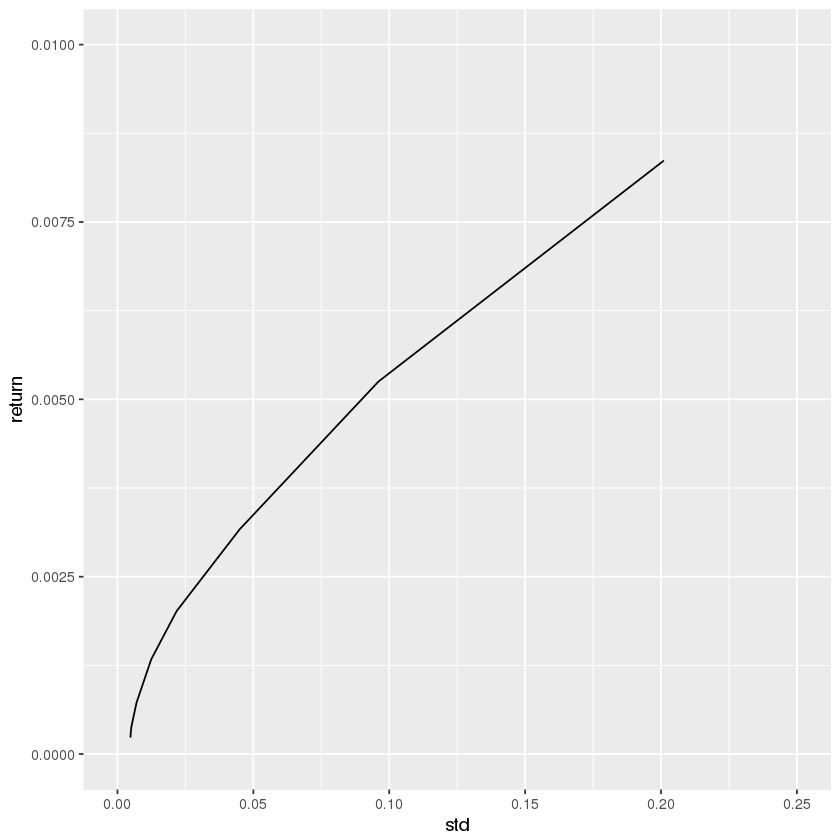

In [26]:
data = data.frame(return = weights %*% c, std = sqrt(diag(weights %*% X %*% t(weights))))
data %>% ggplot() + geom_line(aes(x = std, y = return)) + xlim(0, .25) + ylim(0, .01)